In [1]:
from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

**Instructions to import interval and cartopy**

In [2]:
# To use this cell you will need to pip install pyinterval and cartopy. 
# Uncomment below to do so. Note, pip install had issues for cartopy so 
#                we are using the alternative to installing the package

# The additional packages should be included with a basic anaconda install
#                               but they also may be needed for you to run


# pip install pyinterval
# conda install -c conda-forge cartopy

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from interval import interval, inf, imath   

# Functions for Modeling Orbits & Groundtracking & Tracking Equatorial Coverage 

In [4]:
# Eq. 25, https://en.wikipedia.org/wiki/Kepler_orbit#Properties_of_trajectory_equation
# Note eq. 24 implies a unique E for all t and 0 < e < 1.
t2E = lambda e, t : fsolve(lambda E : E - e*np.sin(E) - t, t/(1 - e))

# Only used in the 2D plot of Earth reference
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

**xy2q is a function that outputs a vector $q$ in $\mathbb{R}^3$. This vector is Earth centered Earth fixed (ECEF).**

The inputs are:

>time

>x coordinate in the orbital plane

>y coordinate in the orbital plane

>i - inclination angle

>ω - argument of perigee 

>Ω - longitude of the ascending node

In [5]:
def xy2q(t, x, y, i, ω, Ω) :                       # map orbit to 3D coordinates (x,y) to (q[0],q[1],q[2])
    W = [np.cos(Ω), np.sin(Ω)]                     # longitude of the ascending node converted to its cosine and sine
    ν = np.sin(i)                                  # sine of inclination angle
    l = ω + 2*np.pi*t/24/3600                      # time (s) converted to orbital plane normal-vector azimuth (radian)
                                                   # little omega is the arugment of pergigree
    ν = np.array([np.cos(l)*ν, np.sin(l)*ν, np.array([np.cos(i)]*len(l))]).transpose()
                                                   # ν converted to unit normal vector of orbital plane
    λ = np.cross([0, 0, 1], ν)                     # vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,axis=1)**-.5)@λ
                                                   # normalize λ
    μ = np.cross(ν, λ)                             # unit vector orthogonal to λ and to ν
    q = (np.diag(x)@λ + np.diag(y)@μ)@np.array([[W[0], -W[1], 0],
                                                [W[1],  W[0], 0],
                                                [   0,     0,  1]])
    return q


In [6]:
def coverage_correction_left(interval_correct):
    # Capture what we need
    left_endpoint = interval_correct[0]
    area_covered = interval([0,left_endpoint[1]])
    
    # Remove the negative portion of the crossing
    for i in range(1,np.size(interval_correct,0)):
        area_covered = interval(area_covered) | interval(interval_correct[i])
        
    # Capture the crossing on the other part of the interval
    dist_passed = abs(left_endpoint[0])
    right_int = [2*np.pi - dist_passed, 2*np.pi]
    
    # Insert interval on the end of area_covered
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

def coverage_correction_right(interval_correct):
    # Capture what we need
    right_endpoint = interval_correct[-1]
    area_covered = interval([right_endpoint[0],2*np.pi])
    
    # Remove the negative portion of the crossing
    for i in range(0,np.size(interval_correct,0)-1):
        area_covered = interval(area_covered) | interval(interval_correct[i])
        
    # Capture the crossing on the other part of the interval
    dist_passed = abs(right_endpoint[1])
    right_int = [0, dist_passed - 2*np.pi]
    
    # Insert interval on the end of area_covered
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

**Outputs a swath length in meters**

swath_coverage inputs:

> theta: angle of camera converage
    
> h: height of camera above the ground

In [7]:
def swath_coverage(theta, h):
    swath = (2 * h * np.tan( ( (np.pi / 180) / 2 ) * theta ))  
    return swath

# User inputs

>time the satellites should run in days 

>number of satellites

>altitude of the satellites in meters

>eccentricity of the orbit

>inclination of the orbital plane

>Earth radius for simulation

In [34]:
# number of days we want to simulate
num_days = 1

# number of satellites we wish to simulate -- << 13
satellites = 11

# altitude in meters
h = 400000

# eccentricity
e = .01 

# np.sin takes radians ==> 83° × π/180 = 1.449 rad
inclination = 1.449

# mean earth radius, m https://en.wikipedia.org/wiki/Earth_radius
# can be changed to 6378.1343e3 --> This value will convert to exactly
# 40,075 km when evaluating coverage. The mean Earth radius will yield 
# a maximum of 40,035 km
R = 6371.0088e3                 

# Setting the Keplerian Orbit

In [35]:
G = 6.67430e-11                 # gravitational constant, m³/(kg s²) https://en.wikipedia.org/wiki/Gravitational_constant
m = [1e3, 5.9722e24]            # masses of satellite, earth, kg https://en.wikipedia.org/wiki/Earth_mass
N = 350                         # nu. plot points
α = G*sum(m)                    # gravitational parameter, eq. 1, m³/s²
a = (R + h)/(1 - e)             # eq. 35, R + minimum altitude solved for semi-major axis, m
p = a*(1 - e*e)                 # eqs. 13--14, r(θ=π/2), θ being the true anomaly
b = a*(1 - e*e)**.5             # eq. 15, semi-minor axis
H = (α*p)**.5                   # eq. 26, specific relative angular-momentum magnitude, m²/s
P = 2*np.pi*a**1.5/α**.5        # eq. 43, orbital period for an elliptic orbit, s

opd = (24*60*60) / P            # roughly 16 orbits in one day -- exactly for a period of 1.5 hours
orbits = (num_days)*opd         # number of orbits we will simulate
swath = swath_coverage(30,h)    # swath based on calculation of altitude 
s = swath/2                     # half the length

**Plotting the orbital plane in 2D**

<IPython.core.display.Javascript object>


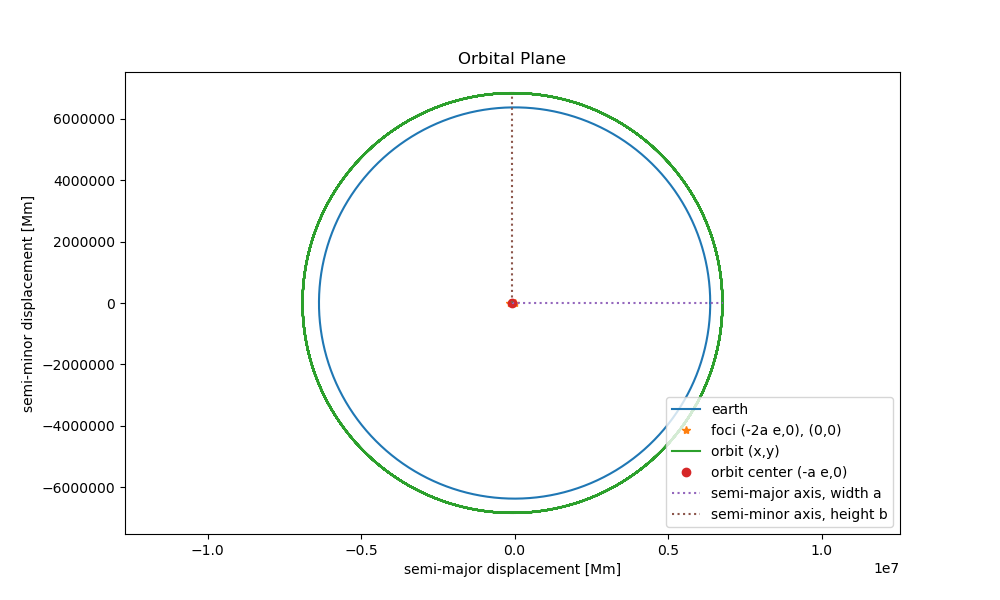

Text(0.5, 1.0, 'Orbital Plane')

In [36]:
%matplotlib notebook
X = circlexy(R,np.linspace(0, 2*np.pi, N)) # curve of earth section by orbital plane 
t = np.linspace(0, orbits*P, 4*N)              # time list
E = t2E(e, H*t/a/b)                            # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)                          # eq. 20, x-coordinate list
y = b*np.sin(E)                                # eq. 21, y-coordinate list

f = plt.figure(figsize=(10,6))
ax = [f.add_subplot(1,1,1)]

ax[0].plot(X[0], X[1], label='earth')
ax[0].plot([0, -2*a*e], [0, 0], '*', label='foci (-2a e,0), (0,0)')
ax[0].plot(x, y, label='orbit (x,y)')
ax[0].plot(-a*e, 0, 'o', label='orbit center (-a e,0)')
ax[0].plot(np.array([-e, 1 - e])*a, np.array([0, 0]), ':', label='semi-major axis, width a')
ax[0].plot(-np.array([1, 1])*a*e, np.array([0, 1])*b, ':', label='semi-minor axis, height b')
ax[0].set_xlabel('semi-major displacement [Mm]')
ax[0].set_ylabel('semi-minor displacement [Mm]')
ax[0].axis('equal')
ax[0].legend(loc='lower right')
ax[0].set_title('Orbital Plane')


**This next cell creates an array of time values at which the positions of the satellite will be computed.** 

> E is an array of eccentric anomalies, where each component is a function of the eccentricity and time.

> x and y are the cartesian coordinates of the satellite in the orbital plane.

For the number of satellites being simulated, a call to the function xy2q is done which transforms the orbital-plane to a 3-dimensional coordinate-system. Each call generates x,y,z coordinates as the orbit evolves in time, q is an array the size of the number of satellites being simulated.

In [37]:
t = np.linspace(0, orbits*P, 4*N)     # time list, s
E = t2E(e, H*t/a/b)                   # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)                 # eq. 20, x-coordinate list
y = b*np.sin(E)                       # eq. 21, y-coordinate list
q = [0]*satellites                    # empty array of size number of satellites

# Ω, the longitude of the ascending node will rotate by one degree every day. 
#    This ensures that the orbital plane passes through the same time on each
#                                                       day at each latitude.

Ω = np.pi/4

# This needs to be set up in a better way, so that the orbits aren't as close
# to each other.
ω = np.linspace(.12,2*np.pi-.15,satellites+1)

for i in range(0,satellites):         # get x,y,z - coords. for each satellite desired
    q[i] = xy2q(t, x, y, inclination, ω[i], Ω)

**Plotting the orbit(s) around a fixed *invisible* Earth.**

<IPython.core.display.Javascript object>


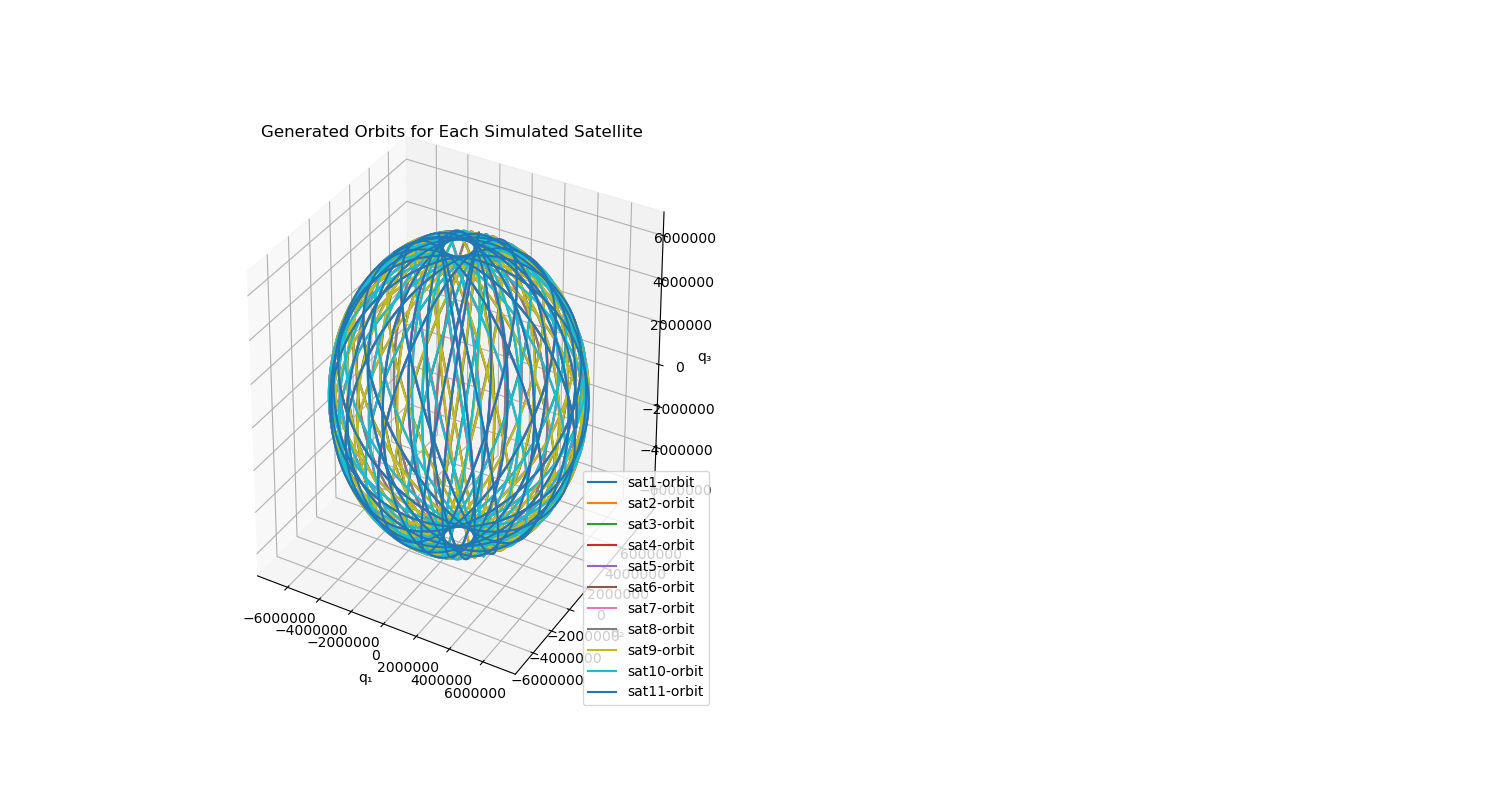

In [38]:
%matplotlib notebook
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,2,1,projection='3d')
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(q[i][:,0], q[i][:,1], q[i][:,2], label=title)
ax.set_xlabel('q₁')
ax.set_ylabel('q₂')
ax.set_zlabel('q₃')
ax.set_title('Generated Orbits for Each Simulated Satellite')
ax.legend(loc='lower right')

**Converting the 3-coordinate system for groundtracking**

$\psi = \tan^{-1} \big( \frac{q_x}{q_y} \big)$ is the logintudinal coordinate for ground tracking.

$\phi = \sin^{-1} \big( \frac{q_z}{|q|} \big)$ is the latitudinal coordinate for ground tracking.

In [40]:
# convert for ground-tracking
psi = [0]*satellites
phi = [0]*satellites

for i in range(0,satellites):
    psi[i] = np.arctan2(q[i][:,0], q[i][:,1])   # x-coordinate for groundtracking
    qq = np.zeros(np.size(q[i][:,2]))
    for j in range(0,np.size(q[i][:,2])):
        qq[j] = q[i][j,2] / np.sqrt( q[i][j,0]**2 + q[i][j,1]**2 + q[i][j,2]**2 )
    phi[i] = np.arcsin( qq )                    # y-coordinate for groundtracking

<IPython.core.display.Javascript object>


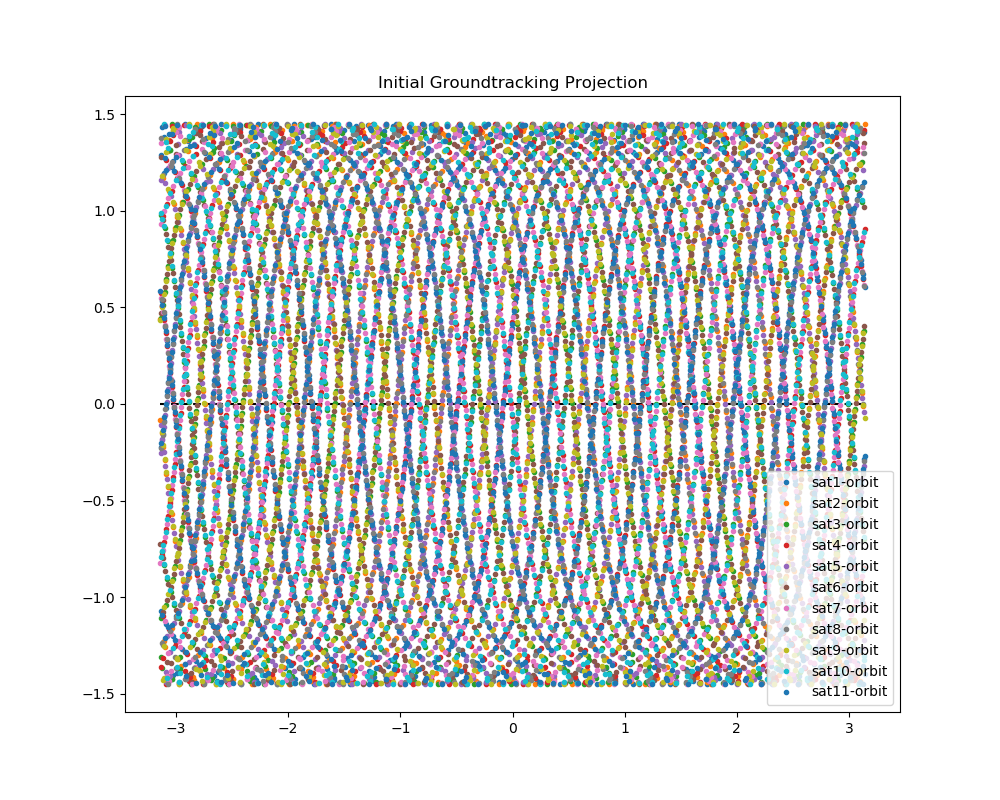

In [41]:
%matplotlib notebook
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)
ax.plot([-np.pi,np.pi],[0,0],'--',c='k')       # equitorial line
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(psi[i], phi[i],'.', label=title )
ax.set_title('Initial Groundtracking Projection')
ax.legend(loc='lower right')

# Beginning Calculating the Swath Coverage

In [42]:
# Finding when the satellite crosses the equator
#   and accumulating the points to form the line

# Setting up parameters needed to find area of
#               swath that crosses the equator
x1 = []
y1 = []
x2 = []
y2 = []

for i in range(0,satellites):
    for j in range(0,np.size(phi[i])-1):
        if( phi[i][j] > 0 and phi[i][j+1] < 0 ):
            x1.append( psi[i][j] )            # x1
            x2.append( psi[i][j+1] )          # x2
            y1.append( phi[i][j] )            # y1
            y2.append( phi[i][j+1] )          # y2
        else:
            if( phi[i][j] < 0 and phi[i][j+1] > 0 ):
                x1.append( psi[i][j] )            # x1
                x2.append( psi[i][j+1] )          # x2
                y1.append( phi[i][j] )            # y1
                y2.append( phi[i][j+1] )          # y2

In [43]:
# Calculating slope of the line crossing the equator.

n = np.size(x1)
slope = []
for i in range(0,n):
    m1 = y1[i] - y2[i]
    m2 = x1[i] - x2[i]
    m  = ( m1 / m2 )
    slope.append( m )  

In [44]:
# Centering a point at the equitorial line (a1,b1) each time we cross the equator

# Setting up parameters in order to center a point on an interpolated line at the equator
#       and to calculate the length of the swath crossing the equator, given our angle of  
#                                                                             inclination
u1 = []
v1 = []
a1 = []
b1 = []

for i in range(0,n):
    u1.append( x2[i] - x1[i] )
    v1.append( y2[i] - y1[i] )        

for i in range(0,n):
    a1.append( x1[i] - (u1[i]/v1[i])*y1[i] )
    b1.append( 0 )    

<IPython.core.display.Javascript object>


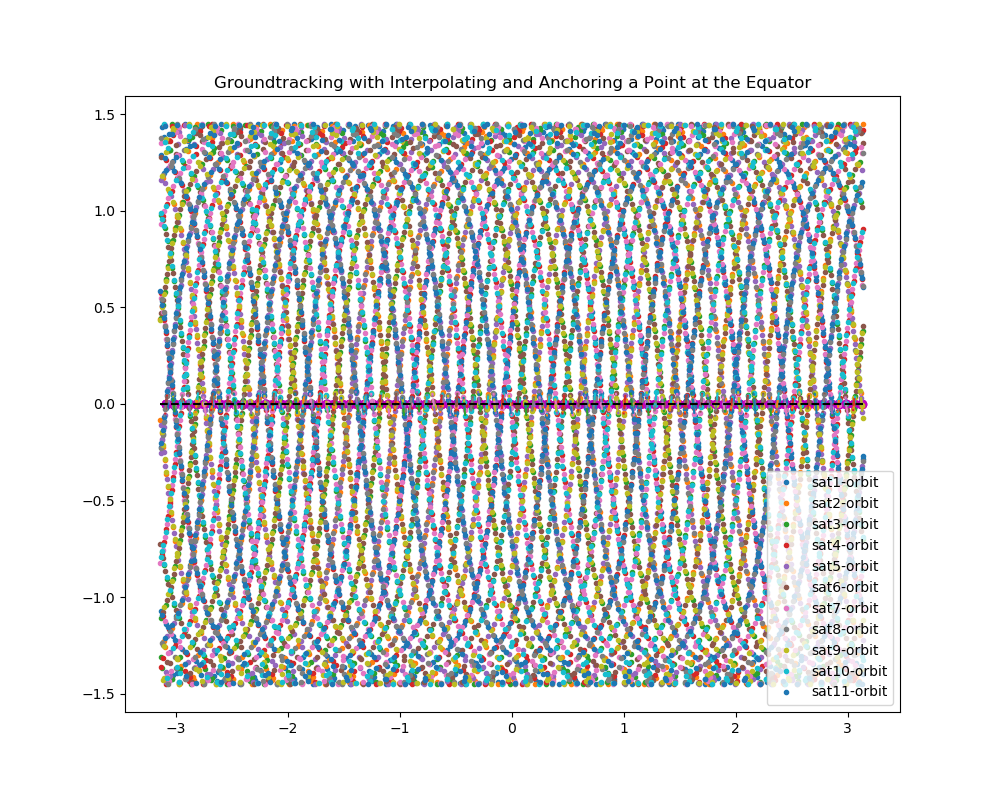

In [45]:
# Plotting the interpolated line for each crossing of the equator
%matplotlib notebook

f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(psi[i], phi[i],'.', label=title )
for i in range(0,np.size(x1)):
    ax.plot([x1[i], x2[i]],[y1[i], y2[i]],'--')
ax.plot([-np.pi,np.pi],[0,0],'--',c='k')
ax.scatter(a1,b1, c='m')
ax.set_title('Groundtracking with Interpolating and Anchoring a Point at the Equator')
ax.legend(loc='lower right')


Calculating swath given the angle as we cross the equator

In [46]:
# Calculation of the swath length given our angle

# Converting meters to radians 
m2r = (1/111320) * (1/57.2958)

swath_length = []
for i in range(0,np.size(slope)):
    swath_length.append( s / np.sin( np.arctan( slope[i] ) ) )

for i in range(0,np.size(swath_length)):
    swath_length[i] = swath_length[i] * m2r
#print(s,'\n')    
#print(swath_length)

In [47]:
# Capturing the interval for each pass accross the equator
# Setting up parameters to track the coverage as we pass the equator
equator_catch_plus  = []
equator_catch_minus = []

for i in range(0,n):
    equator_catch_plus.append( a1[i] + swath_length[i] )
    equator_catch_minus.append( a1[i] - swath_length[i] )

<IPython.core.display.Javascript object>


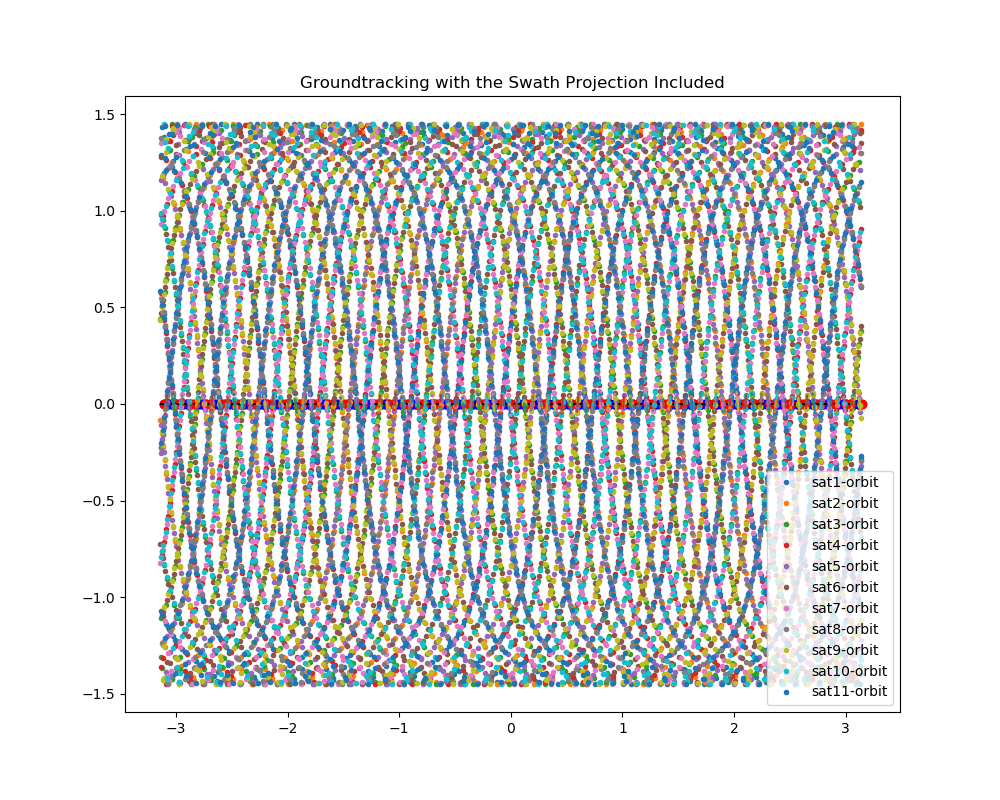

In [48]:
# Plotting the swath for each crossing of the equator
%matplotlib notebook

f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)

ax.plot([-np.pi,np.pi],[0,0],'--',c='k')
ax.scatter(a1,b1, c='m')
ax.scatter(equator_catch_plus,b1,c='b')
ax.scatter(equator_catch_minus,b1,c='r')
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(psi[i], phi[i],'.', label=title )
for i in range(0,np.size(x1)):
    ax.plot([x1[i], x2[i]],[y1[i], y2[i]],'--')
ax.set_title('Groundtracking with the Swath Projection Included')
ax.legend(loc='lower right')

Combining the overlapping intervals

In [49]:
# Comparing each interval we've crossed through periods and combining 
#     overlapping intervals. As well as offsetting the interval we've 
#         caught so instead of looking at [-pi,pi] we look at [0,2pi]
#       this should be easier to convert to a scale needed to compare
#                           with the equitorial coverage of the Earth

interval_caught1    = []
interval_caught2    = []
m = np.size(equator_catch_plus)

# First pass over the (maybe sunny side) equator
for i in range(0,m,2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught1.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
    else:
        interval_caught1.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
# Second pass over the (maybe night side) equator
for i in range(1,m,2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught2.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
    else:
        interval_caught2.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
    
print(np.size(interval_caught1,0),interval_caught1,'\n')
print(np.size(interval_caught2,0),interval_caught2)
print('\n')

# This places the first interval within area_passed_over_eq_i
area_passed_over_eq1 = interval_caught1[0]
area_passed_over_eq2 = interval_caught2[0]

# Combining the union of intervals
m1 = np.size(interval_caught1,0)
m2 = np.size(interval_caught2,0)

for i in range(1,m1):
    area_passed_over_eq1 = interval( area_passed_over_eq1 ) | interval( interval_caught1[i] )
for i in range(1,m2):
    area_passed_over_eq2 = interval( area_passed_over_eq2 ) | interval( interval_caught2[i] )
    
print(np.size(area_passed_over_eq1,0),area_passed_over_eq1)
print('\n')
print(np.size(area_passed_over_eq2,0),area_passed_over_eq2)

165 [[0.44361670059363467, 0.4778225593085259], [0.03425932419333044, 0.06846533235544694], [5.9080864754384095, 5.9422927826679945], [5.4987271295349975, 5.532933791567456], [5.089368410666524, 5.123574651392208], [4.680010705529575, 4.714216674838115], [4.270653543486174, 4.304859390952827], [3.8612964547914217, 3.8955023298504017], [3.4519389698486385, 3.4861450219660957], [3.042580618464882, 3.076786997311968], [2.6332211935800416, 2.6674277665088715], [2.2238626974030704, 2.25806887673588], [1.8145051279462445, 1.8487110635015223], [1.4051480147928888, 1.439353856106791], [0.9957908882819559, 1.0299967847815337], [6.180148798029622, 6.214354656744513], [5.770791421629318, 5.804997429791435], [5.36143326569481, 5.395639572924395], [4.952073919791398, 4.9862805818238565], [4.542715200922926, 4.57692144164861], [4.133357495785978, 4.167563465094516], [3.724000333742575, 3.7582061812092284], [3.314643245047823, 3.348849120106803], [2.90528576010504, 2.939491812222497], [2.495927408721

These correct any swath that is projected beyond our $[0,2\pi]$ range

In [50]:
# Post processing:
# We have a case where we go beyond the [0,2pi] range.
# This cell is fixing the left endpoint

# Setting tolerance in which we want to consider
#         the distance traveled beyond or domain
tol = -1e-10

# This checks the boolean of how negative the left end-point is
boo = tol in interval(area_passed_over_eq1[0])
if( boo == True ):
    print('1\n')
    print(area_passed_over_eq1)
    print('\n')
    area_passed_over_eq1 = coverage_correction_left(area_passed_over_eq1)
    print(area_passed_over_eq1)

print('\n')
boo = tol in interval(area_passed_over_eq2[0])
if( boo == True ):
    print('2\n')
    print(area_passed_over_eq2)
    print('\n')
    area_passed_over_eq2 = coverage_correction_left(area_passed_over_eq2)    
    print(area_passed_over_eq2)

In [51]:
# Now to fix the right endpoint if we go past 2*pi

# Post processing:
#    We have a case where we go beyond the [0,2pi] range.
tol = 1e-10

# This checks the boolean of how negative the left end-point is
boo = 2*np.pi + tol in interval(area_passed_over_eq1[-1])

if( boo == True ):
    print('1\n')
    print(area_passed_over_eq1)
    area_passed_over_eq1 = coverage_correction_right(area_passed_over_eq1)
    print('\n')
    print(area_passed_over_eq1)

print('\n')
boo = 2*np.pi + tol in interval(area_passed_over_eq2[-1])
if( boo == True ):
    print('1\n')
    print(area_passed_over_eq2)
    area_passed_over_eq2 = coverage_correction_right(area_passed_over_eq2)
    print('\n')
    print(area_passed_over_eq2)



1

interval([0.10061734002575129, 0.1403278924593132], [0.23791278715063147, 0.27509800129420814], [0.3752089070438882, 0.4123930643703462], [0.5125051643501952, 0.5496867654029591], [0.6472705497693503, 0.6869811022029126], [0.78456599689423, 0.8217512110378076], [0.9218621167874868, 0.9590462741139456], [1.0591583740937938, 1.0963399751465586], [1.193923759512949, 1.233634311946511], [1.3312192066378288, 1.3684044207814068], [1.4685153265310857, 1.5056994838575448], [1.6058115838373925, 1.6429931848901564], [1.7405769692565476, 1.7802875216901102], [1.8778724163814278, 1.9150576305250044], [2.0151685362746843, 2.0523526936011427], [2.15040236968761, 2.1896463946337557], [2.287230179000147, 2.326940731433708], [2.4245256261250265, 2.461710840268604], [2.559760653206047, 2.5990059033447417], [2.6970555794312085, 2.7362996043773533], [2.8338833887437453, 2.8735939411773073], [2.969118003324591, 3.008364050012202], [3.1064138629496454, 3.14565911308834], [3.2437087891748075, 3.28295281

In [52]:
# Now we convert this output in relation to the circumference of Earth -- 40,075 km
area_passed_over_eq1_new = area_passed_over_eq1 * (R/1000) # convert to distance traveled in km
area_passed_over_eq2_new = area_passed_over_eq2 * (R/1000) # convert to distance traveled in km
print('1 ',area_passed_over_eq1_new,'\n')
print('2 ',area_passed_over_eq2_new)

1  interval([205.11483281907996, 455.2470453915618], [1079.8192423760252, 1329.9572247514168], [1954.530110425434, 2204.6712639208745], [2813.146827931964, 3079.386169990145], [3687.8472426437916, 3937.9794552162684], [4562.551652200731, 4812.689634576134], [5421.1712417424815, 5687.403673745586], [6295.879237756672, 6562.118579814857], [7170.579652468503, 7420.711865040983], [8029.19068913373, 8295.422044400846], [8903.90365156719, 9170.136083570298], [9778.61164758139, 10028.740954142942], [10653.312062293215, 10903.444274865695], [11511.923098958441, 11778.154454225558], [12386.636061391902, 12636.772215950696], [13261.344057406099, 13511.473363967654], [14136.044472117923, 14386.176684690407], [14994.655508783155, 15247.755775464284], [15869.368471216616, 16119.504625775411], [16744.076467230814, 16994.205773792368], [17618.776881942642, 17855.77327921973], [18477.387918607867, 18730.488185289007], [19352.100881041326, 19602.237035600123], [20226.808877055526, 20463.79164987499], [

In [53]:
total_coverage1 = 0
total_coverage2 = 0
mm1 = ( int(float(np.size(area_passed_over_eq1_new) / 2)) )
mm2 = ( int(float(np.size(area_passed_over_eq2_new) / 2)) )

for i in range(0,mm1):
    total_coverage1 = total_coverage1 + ( area_passed_over_eq1_new[i][1] - area_passed_over_eq1_new[i][0])
total_coverage1 = str(total_coverage1)
print('The total coverage at the equator is  ' + total_coverage1 + ' km' )

for i in range(0,mm2):
    total_coverage2 = total_coverage2 + ( area_passed_over_eq2_new[i][1] - area_passed_over_eq2_new[i][0])
total_coverage2 = str(total_coverage2)
print('The total coverage at the equator is  ' + total_coverage2 + ' km' )

The total coverage at the equator is  11429.302043793692 km
The total coverage at the equator is  11424.868299315593 km


# Plotting the Groundtracking

<IPython.core.display.Javascript object>


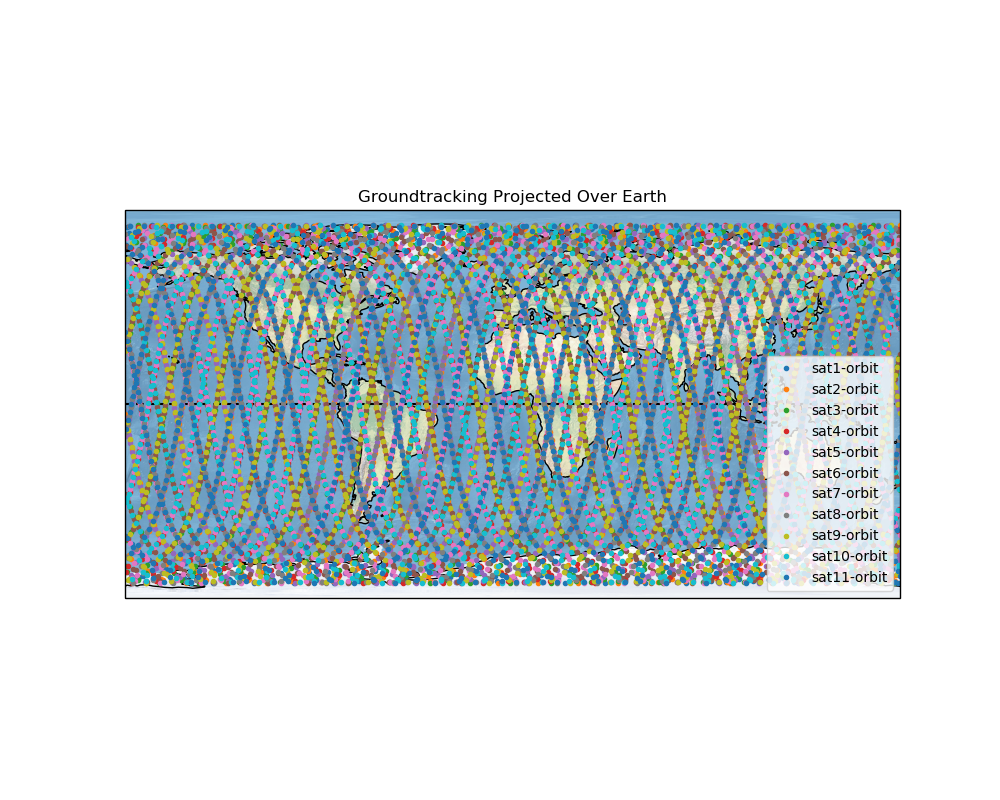

In [54]:
# Plotting the groundtracking of the satellite orbits
%matplotlib notebook

src_crs = ccrs.PlateCarree()
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=src_crs)
ax.stock_img()
ax.coastlines()
ax.plot([-180,180],[0,0],'--',c='k')   
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    lon = psi[i] # [-pi,pi]
    lat = phi[i] # [-pi/2,pi/2]
    # converting to degrees
    lon = lon * (180/np.pi)
    lat = lat * (180/np.pi)
    ax.plot(lon,lat,'.', label=title)
ax.set_title('Groundtracking Projected Over Earth')
ax.legend(loc='lower right')

In [55]:
equator_inta1 = []
equator_intb1 = []
for i in range(0,int(float(np.size(area_passed_over_eq1)/2))):
    equator_inta1.append(area_passed_over_eq1[i][0] - np.pi)
    equator_intb1.append(area_passed_over_eq1[i][1] - np.pi)

In [56]:
equator_inta2 = []
equator_intb2 = []
for i in range(0,int(float(np.size(area_passed_over_eq2)/2))):
    equator_inta2.append(area_passed_over_eq2[i][0] - np.pi)
    equator_intb2.append(area_passed_over_eq2[i][1] - np.pi)

<IPython.core.display.Javascript object>


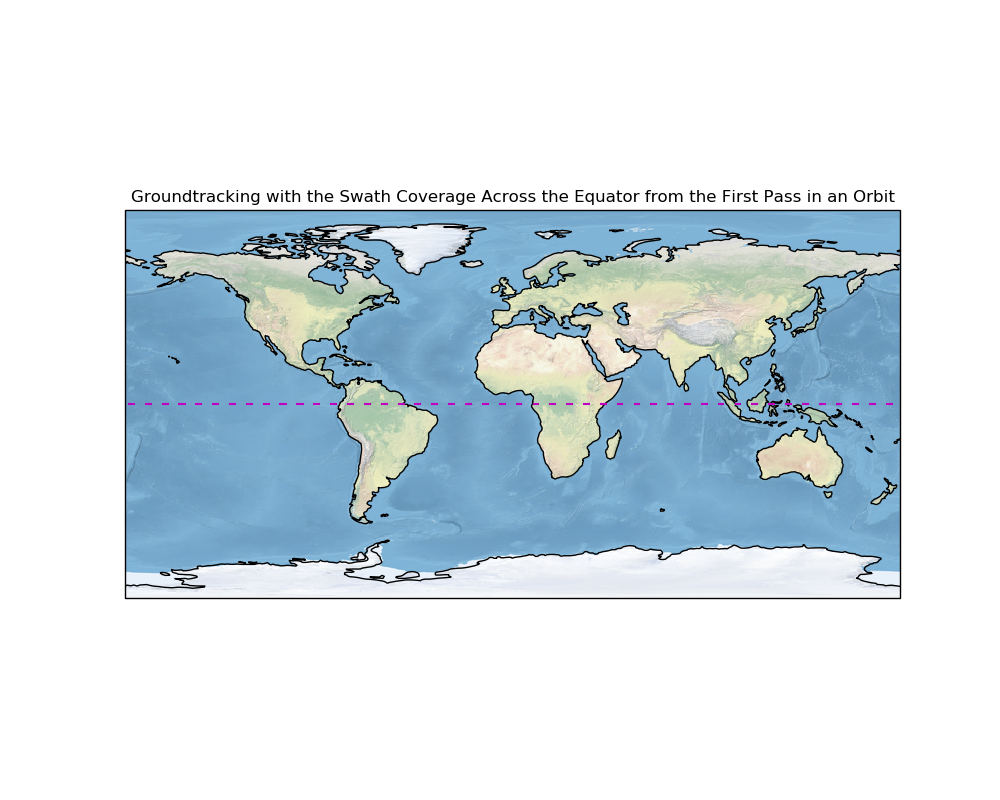

Text(0.5, 1.0, 'Groundtracking with the Swath Coverage Across the Equator from the First Pass in an Orbit')

In [57]:
# Plotting the groundtracking of the satellite orbits
%matplotlib notebook

src_crs = ccrs.PlateCarree()
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=src_crs)
ax.stock_img()
ax.coastlines()
for i in range(0,np.size(equator_inta1)):
    ax.plot([equator_inta1[i]*(180/np.pi),equator_intb1[i]*(180/np.pi)],[0,0],'-',c='m')
ax.set_title('Groundtracking with the Swath Coverage Across the Equator from the First Pass in an Orbit')

<IPython.core.display.Javascript object>


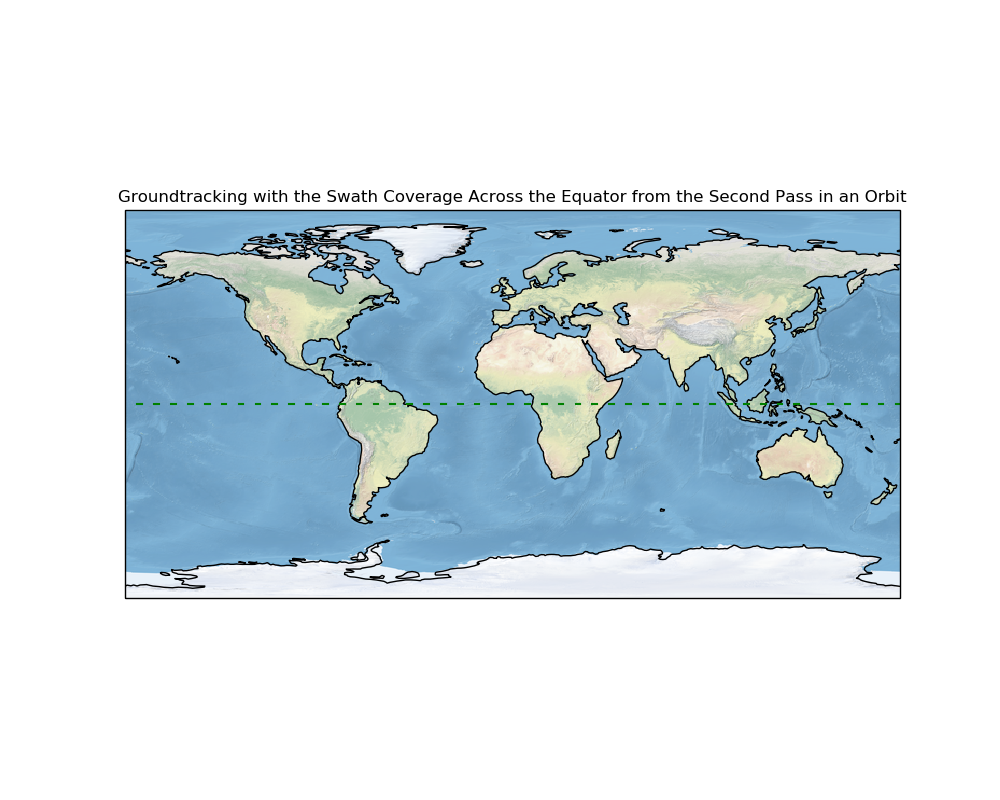

Text(0.5, 1.0, 'Groundtracking with the Swath Coverage Across the Equator from the Second Pass in an Orbit')

In [59]:
# Plotting the groundtracking of the satellite orbits
%matplotlib notebook

src_crs = ccrs.PlateCarree()
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=src_crs)
ax.stock_img()
ax.coastlines()
#ax.plot([-180,180],[0,0],'--',c='k')
for i in range(0,np.size(equator_inta2)):
    ax.plot([equator_inta2[i]*(180/np.pi),equator_intb2[i]*(180/np.pi)],[0,0],'-',c='g')
ax.set_title('Groundtracking with the Swath Coverage Across the Equator from the Second Pass in an Orbit')

<IPython.core.display.Javascript object>


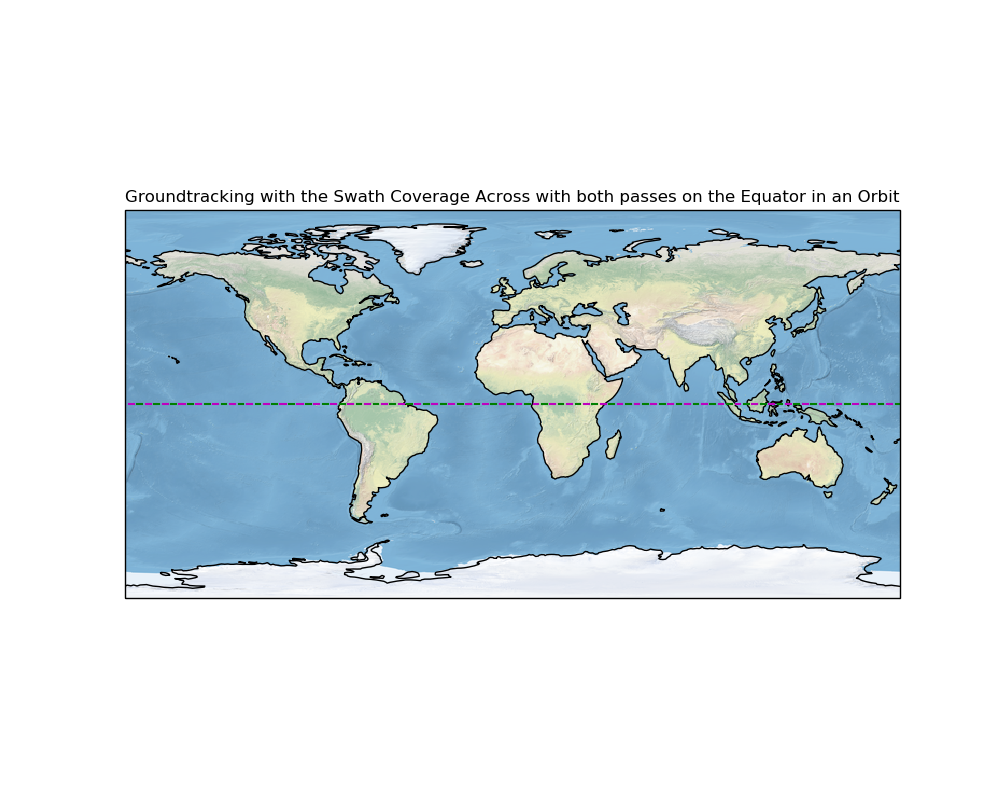

Text(0.5, 1.0, 'Groundtracking with the Swath Coverage Across with both passes on the Equator in an Orbit')

In [58]:
# Plotting the groundtracking of the satellite orbits
%matplotlib notebook

src_crs = ccrs.PlateCarree()
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=src_crs)
ax.stock_img()
ax.coastlines()
#ax.plot([-180,180],[0,0],'--',c='k')
for i in range(0,np.size(equator_inta2)):
    ax.plot([equator_inta2[i]*(180/np.pi),equator_intb2[i]*(180/np.pi)],[0,0],'-',c='g')
for i in range(0,np.size(equator_inta1)):
    ax.plot([equator_inta1[i]*(180/np.pi),equator_intb1[i]*(180/np.pi)],[0,0],'-',c='m')
ax.set_title('Groundtracking with the Swath Coverage Across with both passes on the Equator in an Orbit')